# Deblurring Images

In [2]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
plt.set_cmap('binary')

<Figure size 640x480 with 0 Axes>

## Blurring images by Toeplitz matrices

Represent a image as a matrix $X$. Use the function [`scipy.linalg.toeplitz`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.toeplitz.html) to create a Toeplitz matrices $A_c$ and $A_r$. Matrix multiplication on the left $A_c X$ blurs vertically (in the columns) and on the right $X A_r$ blurs horizontally (in the rows).

Let us create a $N \times N$ matrix of zeros and ones such that represents the image of square.

In [4]:
N = 256

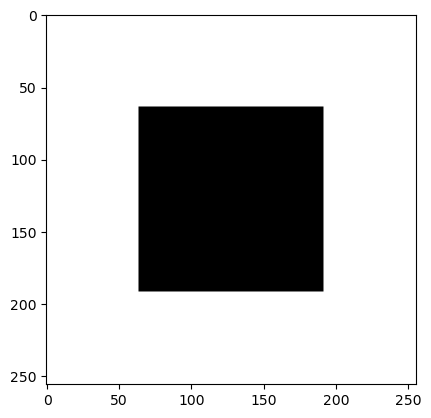

In [5]:
Z = np.zeros((N//4,N//4))
O = np.ones((N//4,N//4))
X = np.block([[Z,Z,Z,Z],[Z,O,O,Z],[Z,O,O,Z],[Z,Z,Z,Z]])
plt.imshow(X)
plt.show()

Create a Toeplitz matrix where the values decrease linearly from the diagonal.

In [6]:
c = np.zeros(N)
s = 5
c[:s] = (s - np.arange(0,s))/(3*s)
Ac = la.toeplitz(c)

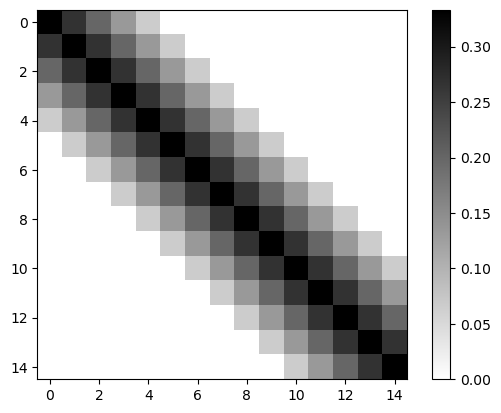

In [7]:
plt.imshow(Ac[:15,:15])
plt.colorbar()
plt.show()

Check the condition number of $A_c$.

In [8]:
np.linalg.cond(Ac)

24782.331042553396

Blur the image $X$ vertically.

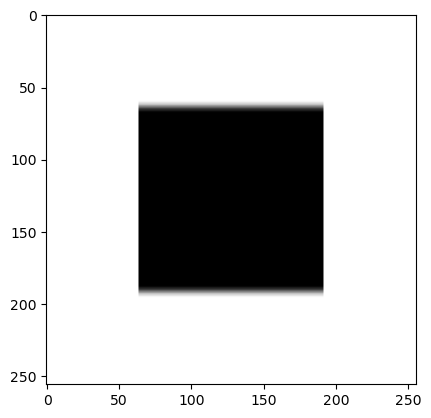

In [9]:
plt.imshow(Ac @ X)
plt.show()

Do the same but in the horizontal direction.

In [10]:
r = np.zeros(N)
s = 20
r[:s] = (s - np.arange(0,s))/(3*s)
Ar = la.toeplitz(r)

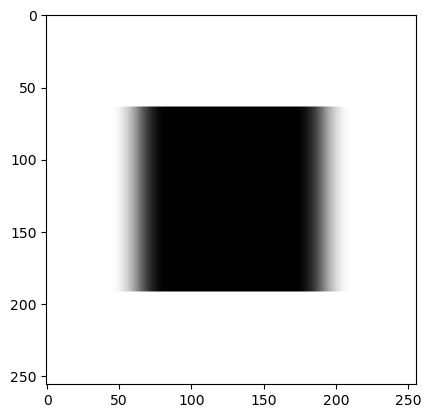

In [11]:
plt.imshow(X @ Ar.T)
plt.show()

Combine both vertical and horizontal blurring.

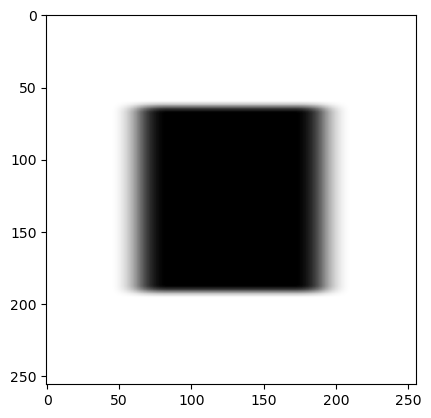

In [12]:
plt.imshow(Ac @ X @ Ar.T)
plt.show()

## Inverting the noise

Let $E$ represent some noise in the recording of the image

$$
A_c X A_r^T = B + E
$$

How do we find $X$?

In [13]:
url = 'https://raw.githubusercontent.com/adrs0049/MATH545/master/notebooks/data/kitten.jpg'
page = requests.get(url)
kitten = np.asarray(Image.open(BytesIO(page.content))).astype(np.float64)

In [14]:
kitten.shape

(256, 256)

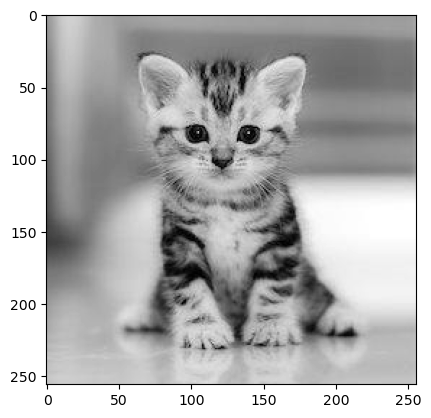

In [15]:
plt.imshow(kitten,cmap='gray')
plt.show()

In [16]:
B = Ac@kitten@Ar.T + 0.01*np.random.randn(256,256)

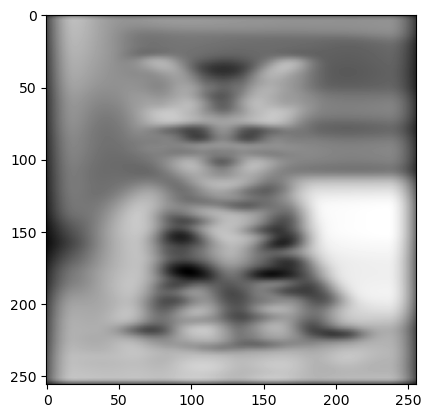

In [17]:
plt.imshow(B,cmap='gray')
plt.show()

In [18]:
X1 = la.solve(Ac,B)
X2 = la.solve(Ar,X1.T)
X2 = X2.T

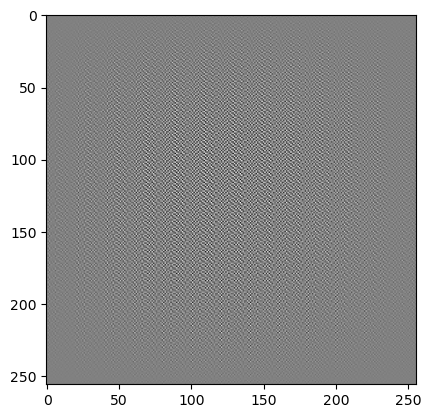

In [19]:
plt.imshow(X2,cmap='gray')
plt.show()

## Truncated SVD

We need to avoid inverting the noise therefore we compute using the truncated pseudoinverse

$$
X = (A_c)_k^+ B (A_r^T)_k^+
$$

In [20]:
Pc,Sc,QTc = la.svd(Ac)

In [21]:
Pr,Sr,QTr = la.svd(Ar)

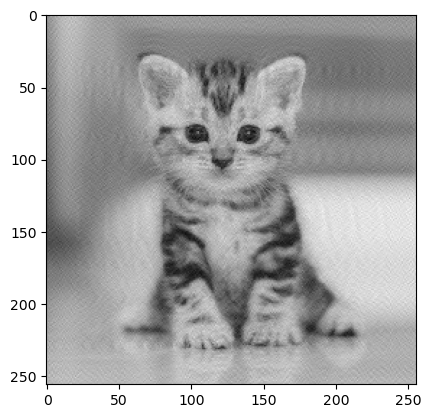

In [22]:
k = 200
Dc_k_plus = np.hstack([1/Sc[:k],np.zeros(N-k)])
Dr_k_plus = np.hstack([1/Sr[:k],np.zeros(N-k)])
Ac_k_plus = QTc.T @ np.diag(Dc_k_plus) @ Pc.T
Ar_k_plus = Pr @ np.diag(Dr_k_plus) @ QTr
X = Ac_k_plus @ B @ Ar_k_plus
plt.imshow(X,cmap='gray')
plt.show()